In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
df1 = pd.read_csv(r'D:\SEM-6\NLP\Project\Kaggle Dataset\train.csv\train.csv')
df2 = pd.read_csv(r'D:\SEM-6\NLP\Project\Kaggle Dataset\youtoxic_english_1000.csv')

In [3]:
df1.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df2.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [5]:
# Process df1
df1['Toxic'] = df1.iloc[:, 2:].any(axis=1)
df1_processed = df1[['comment_text', 'Toxic']].rename(columns={'comment_text': 'Text'})

# Process df2
df2['Toxic'] = df2.iloc[:, 3:].any(axis=1)
df2_processed = df2[['Text', 'Toxic']]

# Combine df1_processed and df2_processed
df = pd.concat([df1_processed, df2_processed], ignore_index=True)

# Display the first few rows of final_df
print(df.head())

                                                Text  Toxic
0  Explanation\nWhy the edits made under my usern...  False
1  D'aww! He matches this background colour I'm s...  False
2  Hey man, I'm really not trying to edit war. It...  False
3  "\nMore\nI can't make any real suggestions on ...  False
4  You, sir, are my hero. Any chance you remember...  False


In [6]:
df.describe()

,Text,Toxic
count,160571,160571
unique,160568,2
top,run them over,False
freq,3,143884


In [7]:
# Check data types and missing values
print(df.dtypes)
print(df.isnull().sum())

Text     object
Toxic      bool
dtype: object
Text     0
Toxic    0
dtype: int64


In [8]:
# Check for duplicate comments
duplicate_rows = df[df.duplicated(subset=['Text'], keep=False)]
print("Duplicate rows based on 'Text' column:")
print(duplicate_rows)

# Drop duplicate comments
df.drop_duplicates(subset=['Text'], keep='first', inplace=True)

# Confirm duplicates are removed
print("Number of rows after removing duplicates:", len(df))

# Reindex the DataFrame after dropping duplicates
df.reset_index(drop=True, inplace=True)

Duplicate rows based on 'Text' column:
                 Text  Toxic
160163  RUN THEM OVER   True
160213  run them over   True
160228  run them over   True
160248  run them over   True
160270  RUN THEM OVER   True
Number of rows after removing duplicates: 160568


In [9]:
# Distribution of 'Toxic' column
toxic_distribution = df['Toxic'].value_counts()
print(toxic_distribution)

Toxic
False    143884
True      16684
Name: count, dtype: int64


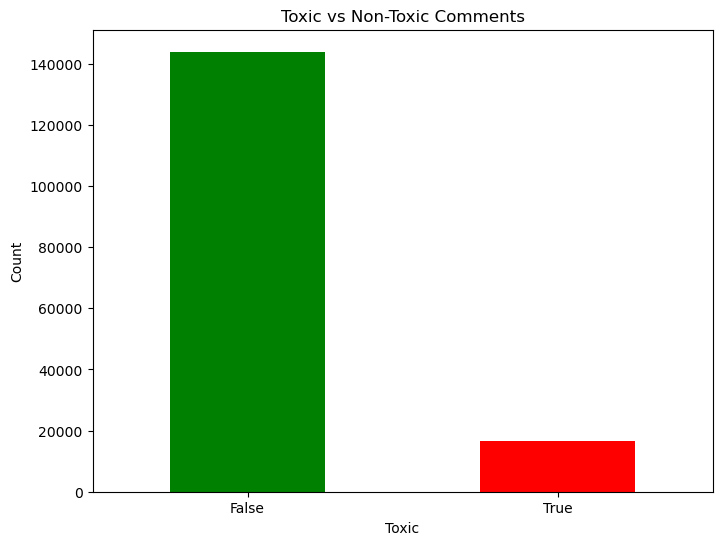

In [10]:
# Bar plot for toxic vs non-toxic comments
plt.figure(figsize=(8, 6))
toxic_counts = df['Toxic'].value_counts()
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Toxic vs Non-Toxic Comments')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

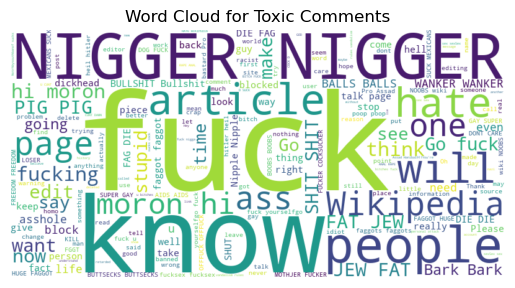

In [11]:
# Word Cloud for toxic and non-toxic comments
toxic_comments = ' '.join(df[df['Toxic']]['Text'])
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white').generate(toxic_comments)
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()

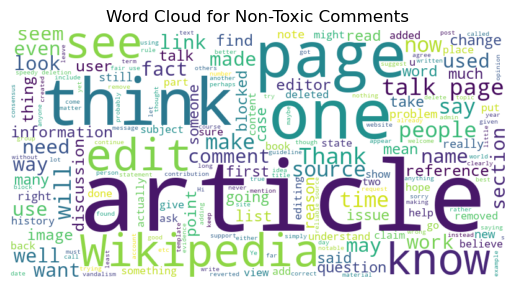

In [12]:
non_toxic_comments = ' '.join(df[~df['Toxic']]['Text'])
wordcloud_non_toxic = WordCloud(width=800, height=400, background_color='white').generate(non_toxic_comments)
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Toxic Comments')
plt.show()

In [13]:
# Convert True to 1 and False to 0 in the 'Toxic' column
df['Toxic'] = df['Toxic'].astype(int)

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

<>:13: SyntaxWarning: invalid escape sequence '\W'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\W'
<>:14: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Dhanush MC\AppData\Local\Temp\ipykernel_31652\1134232812.py:13: SyntaxWarning: invalid escape sequence '\W'
  text = re.sub('\W', ' ', text)
C:\Users\Dhanush MC\AppData\Local\Temp\ipykernel_31652\1134232812.py:14: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [15]:
# clean the comment_text in train_df 
df['Text'] = df['Text'].map(lambda com : clean_text(com))

In [16]:
import torch
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

embedding_dim = 300 
glove_path = r"D:\SEM-6\NLP\Project\Glove\glove.6B.300d.txt" 

# Load GloVe embeddings
word2vec = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Loading GloVe..."):
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype=np.float32)
        word2vec[word] = vector

print(f"Loaded {len(word2vec)} words from GloVe.")

# Tokenizer function
def tokenize(text):
    return text.lower().split()

# Build vocabulary from dataset
counter = Counter()
for text in df["Text"]:
    counter.update(tokenize(text))

# Map words to indices
vocab = {word: idx + 2 for idx, (word, _) in enumerate(counter.most_common())}
vocab["<pad>"] = 0
vocab["<unk>"] = 1

# Create embedding matrix
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, idx in vocab.items():
    if word in word2vec:
        embedding_matrix[idx] = word2vec[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

# Convert to PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)

# Function to convert text to tensor
def text_to_tensor(text, max_length=200):
    tokens = tokenize(text)
    indices = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    indices = indices[:max_length]  # Truncate
    indices += [vocab["<pad>"]] * (max_length - len(indices))  # Pad
    return torch.tensor(indices, dtype=torch.long)

# Convert dataset to tensors
X_tensors = torch.stack([text_to_tensor(text) for text in df["Text"]])
Y_tensors = torch.tensor(df["Toxic"].values, dtype=torch.long)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensors, Y_tensors, test_size=0.2, random_state=42)

# Create DataLoaders
batch_size = 128
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Vocabulary Size: {len(vocab)}")
print(f"Train Samples: {len(train_data)}, Test Samples: {len(test_data)}")


Loading GloVe...: 400000it [00:23, 16746.23it/s]


Loaded 400000 words from GloVe.
Vocabulary Size: 191058
Train Samples: 128454, Test Samples: 32114


In [17]:
from imblearn.over_sampling import ADASYN

X_numpy = X_tensors.numpy()
y_numpy = Y_tensors.numpy()

adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X_numpy, y_numpy)
X_resampled = torch.tensor(X_resampled, dtype=torch.long)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)

print(f"Original shape: {X_numpy.shape}, {y_numpy.shape}")
print(f"Resampled shape: {X_resampled.shape}, {y_resampled.shape}")


Original shape: (160568, 200), (160568,)
Resampled shape: torch.Size([287752, 200]), torch.Size([287752])


In [18]:
# Keep X_resampled and y_resampled as tensors for PyTorch
# Just check the class distribution of the resampled data
import pandas as pd

# No need to convert X_resampled to numpy again if it's already a tensor
if isinstance(X_resampled, torch.Tensor):
    X_resampled_tensor = X_resampled
else:
    X_resampled_tensor = torch.tensor(X_resampled, dtype=torch.long)

# For checking class distribution only
if isinstance(y_resampled, torch.Tensor):
    y_numpy = y_resampled.numpy()
else:
    y_numpy = y_resampled

# Create Series just for displaying distribution
y_series = pd.Series(y_numpy)

# Check class distribution after oversampling
toxic_distribution_after = y_series.value_counts()
print("\nDistribution after ADASYN:")
print(toxic_distribution_after)


Distribution after ADASYN:
0    143884
1    143868
Name: count, dtype: int64


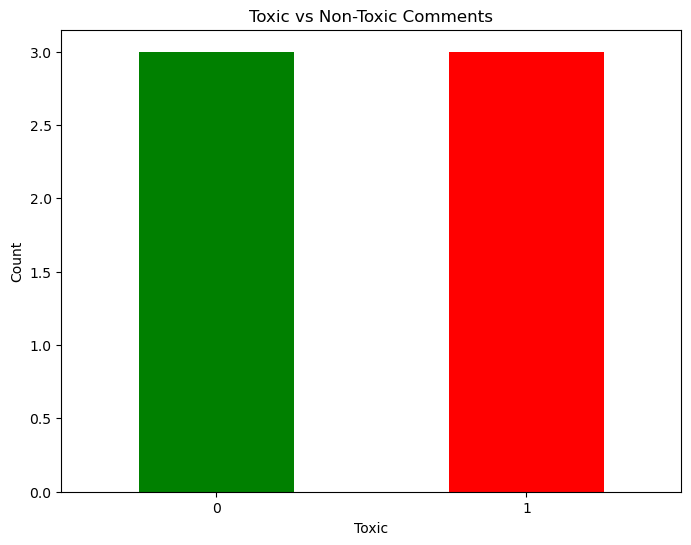

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data (replace this with your actual data loading and preprocessing steps)
data = {
    'Comment': ['This is great!', 'You are stupid', 'Nice work', 'I hate you', 'Well done', 'You are an idiot'],
    'Toxic': [0, 1, 0, 1, 0, 1]
}
df = pd.DataFrame(data)

# Resample the data (example resampling, replace with your actual resampling logic)
df_resampled = df.sample(frac=1, random_state=42)  # Shuffle the data

# Bar plot for toxic vs non-toxic comments
plt.figure(figsize=(8, 6))
toxic_counts = df_resampled['Toxic'].value_counts()
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Toxic vs Non-Toxic Comments')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [20]:
import torch
import torch.nn as nn

class BiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(BiLSTMAttention, self).__init__()
        
        # Add embedding layer initialized with GloVe vectors
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        
        # LSTM layer - takes embedding_dim as input now
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        
        # Attention layers
        self.attention = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.context_vector = nn.Linear(hidden_dim * 2, 1, bias=False)
        
        # Output layers
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
    # x shape: (batch_size, seq_length) - contains word indices
        embedded = self.embedding(x)  # Shape: (batch_size, seq_length, embedding_dim)
    
    # Pass through LSTM
        lstm_out, _ = self.lstm(embedded)  # Shape: (batch_size, seq_len, hidden_dim * 2)
    
    # Attention mechanism
        attn_scores = torch.tanh(self.attention(lstm_out))
        attn_weights = torch.softmax(self.context_vector(attn_scores), dim=1)
    
    # Apply attention weights
        attn_out = torch.sum(lstm_out * attn_weights, dim=1)
    
    # Final classification
        output = self.fc(self.dropout(attn_out))
    
        return output.float()  # Ensure output is float32


In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Parameters
vocab_size = len(vocab)  # Size of your vocabulary
embedding_dim = 300  # GloVe feature dimension
hidden_dim = 256
output_dim = 2  # Binary classification

# Initialize Model with embedding matrix
model = BiLSTMAttention(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    embedding_matrix=embedding_matrix
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1: 100%|██████████| 900/900 [01:44<00:00,  8.62it/s]


Epoch 1, Loss: 0.03205579428312679


Epoch 2: 100%|██████████| 900/900 [02:02<00:00,  7.34it/s]


Epoch 2, Loss: 0.0167553531888148


Epoch 3: 100%|██████████| 900/900 [01:59<00:00,  7.53it/s]


Epoch 3, Loss: 0.010055231711335688


Epoch 4: 100%|██████████| 900/900 [01:26<00:00, 10.37it/s]


Epoch 4, Loss: 0.0070786593362127965


Epoch 5: 100%|██████████| 900/900 [01:22<00:00, 10.95it/s]


Epoch 5, Loss: 0.005311579610602671


Epoch 6: 100%|██████████| 900/900 [01:23<00:00, 10.79it/s]


Epoch 6, Loss: 0.0043554851022620114


Epoch 7: 100%|██████████| 900/900 [01:24<00:00, 10.71it/s]


Epoch 7, Loss: 0.003198716980564819


Epoch 8: 100%|██████████| 900/900 [01:23<00:00, 10.74it/s]


Epoch 8, Loss: 0.0031101677640203384


Epoch 9: 100%|██████████| 900/900 [01:25<00:00, 10.54it/s]


Epoch 9, Loss: 0.0032644503181897258


Epoch 10: 100%|██████████| 900/900 [01:24<00:00, 10.61it/s]


Epoch 10, Loss: 0.00231613268349065


Epoch 11: 100%|██████████| 900/900 [01:24<00:00, 10.66it/s]


Epoch 11, Loss: 0.002507379829963207


Epoch 12: 100%|██████████| 900/900 [01:24<00:00, 10.66it/s]


Epoch 12, Loss: 0.0018486792193875266


Epoch 13: 100%|██████████| 900/900 [01:24<00:00, 10.71it/s]


Epoch 13, Loss: 0.001555425988802502


Epoch 14: 100%|██████████| 900/900 [01:24<00:00, 10.65it/s]


Epoch 14, Loss: 0.001610497821473776


Epoch 15: 100%|██████████| 900/900 [01:25<00:00, 10.53it/s]


Epoch 15, Loss: 0.0018243256067252231


Epoch 16: 100%|██████████| 900/900 [01:24<00:00, 10.64it/s]


Epoch 16, Loss: 0.0017773794859476766


Epoch 17: 100%|██████████| 900/900 [01:23<00:00, 10.74it/s]


Epoch 17, Loss: 0.0013326458632438214


Epoch 18: 100%|██████████| 900/900 [01:23<00:00, 10.76it/s]


Epoch 18, Loss: 0.0010175442650481475


Epoch 19: 100%|██████████| 900/900 [01:22<00:00, 10.88it/s]


Epoch 19, Loss: 0.0009405025551801474


Epoch 20: 100%|██████████| 900/900 [01:23<00:00, 10.76it/s]


Epoch 20, Loss: 0.0011796181297821324
Model saved successfully.


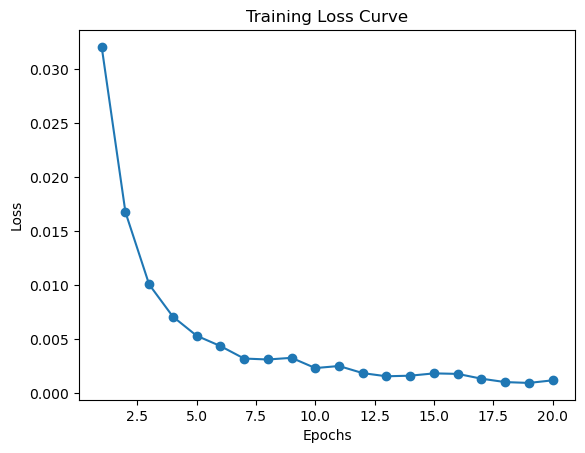

In [23]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Ensure `X_resampled` is a NumPy array
if isinstance(X_resampled, torch.Tensor):
    X_resampled = X_resampled.cpu().numpy()

# Ensure `y_resampled` is a NumPy array
if isinstance(y_resampled, torch.Tensor):
    y_resampled = y_resampled.cpu().numpy()
elif isinstance(y_resampled, pd.Series):
    y_resampled = y_resampled.to_numpy()  # Convert Pandas Series to NumPy array

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Ensure y_train and y_test are NumPy arrays before tensor conversion
y_train = np.array(y_train)  # Explicit conversion
y_test = np.array(y_test)    # Explicit conversion

# Convert `X_resampled` to a LongTensor (as it represents token indices, not embeddings)
X_train = torch.tensor(X_train, dtype=torch.long)  # Ensure token indices are long
X_test = torch.tensor(X_test, dtype=torch.long)    # Ensure it's long type

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Training function with mixed precision
def train_model(model, train_dataloader, epochs=20):
    model.train()
    train_losses = []  # Store losses for plotting
    scaler = GradScaler()  # Initialize GradScaler for mixed precision
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to GPU/CPU
            
            optimizer.zero_grad()
            
            with autocast():  # Enable mixed precision
                outputs = model(X_batch)  # Ensure model receives token indices, embedding happens inside
                loss = criterion(outputs, y_batch)
            
            scaler.scale(loss).backward()  # Scale the loss and backpropagate
            scaler.step(optimizer)  # Update the weights
            scaler.update()  # Update the scaler
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_loss)  # Store loss
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")
    
    torch.save(model.state_dict(), "bilstm_toxicity_model.pth")
    print("Model saved successfully.")
    return train_losses  # Return loss values

# Train the model and store loss values
train_losses = train_model(model, train_dataloader)

# Plot Training Loss
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)  # Ensure model receives token indices, embedding happens inside
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return all_labels, all_preds

# Evaluate the model on the test set
labels, preds = evaluate_model(model, test_dataloader)

Accuracy: 0.9527
Precision: 0.9572
Recall: 0.9479
F1-score: 0.9525
